# Sistema de Recomendação Musical com Spotify (NMF + Similaridade do Cosseno)

Este notebook implementa, na prática, a metodologia de um sistema de recomendação baseado em conteúdo
usando dados públicos de faixas populares do Spotify. O foco é:

- Carregar e explorar a base de dados de músicas e seus atributos de áudio.
- Preparar os dados (limpeza, seleção de atributos, normalização).
- Aplicar **Non-negative Matrix Factorization (NMF)** para extrair fatores latentes.
- Calcular similaridade entre músicas usando **similaridade do cosseno**.
- Gerar recomendações de músicas semelhantes.
- Calcular e exibir métricas simples de desempenho do modelo e uma tabela de recomendações.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

## 1. Carregamento da Base de Dados

A base utilizada é o dataset público **Spotify top songs and audio features**, hospedado em um Gist.


In [2]:
# URL do CSV hospedado no Gist
DATA_URL = "https://gist.githubusercontent.com/akira-fukue/b71f9e9197d9fc737ca7b999d4884993/raw/8141b41fca536c2c4d9b1c3c9e647032282171e5/spotify_top_songs_audio_features.csv"

df = pd.read_csv(DATA_URL)
df.head()

,id,artist_names,track_name,source,key,mode,time_signature,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness,tempo,duration_ms,weeks_on_chart,streams
0,000xQL6tZNLJzIrtIgxqSl,"ZAYN, PARTYNEXTDOOR",Still Got Time (feat. PARTYNEXTDOOR),RCA Records Label,G,Major,4 beats,0.748,0.627,0.0639,0.13100,0.0,0.0852,0.524,-6.029,120.963,188491,17,107527761
1,003eoIwxETJujVWmNFMoZy,Alessia Cara,Growing Pains,Def Jam Recordings,C#/Db,Minor,4 beats,0.353,0.755,0.7330,0.08220,0.0,0.3900,0.437,-6.276,191.153,193680,2,9944865
2,003vvx7Niy0yvhvHt4a68B,The Killers,Mr. Brightside,Island Records,C#/Db,Major,4 beats,0.352,0.911,0.0747,0.00121,0.0,0.0995,0.236,-5.230,148.033,222973,125,512388123
3,00B7TZ0Xawar6NZ00JFomN,"Cardi B, Chance the Rapper",Best Life (feat. Chance The Rapper),Atlantic/KSR,A,Major,4 beats,0.620,0.625,0.5530,0.28700,0.0,0.3140,0.665,-7.438,167.911,284856,2,11985346
4,00Blm7zeNqgYLPtW6zg8cj,"Post Malone, The Weeknd",One Right Now (with The Weeknd),Republic Records,C#/Db,Major,4 beats,0.687,0.781,0.0530,0.03610,0.0,0.0755,0.688,-4.806,97.014,193507,30,301860377


## 2. Análise Exploratória (EDA)

Nesta etapa, vamos entender a estrutura da base: colunas, tipos, distribuição de atributos e possíveis problemas.


In [3]:
# Visão geral do dataset
print("Formato do dataset:", df.shape)
print("\nColunas disponíveis:\n", df.columns.tolist())

print("\nTipos de dados:\n")
print(df.dtypes)

print("\nResumo estatístico dos atributos numéricos:\n")
df.describe().T

Formato do dataset: (6513, 19)

Colunas disponíveis:
 ['id', 'artist_names', 'track_name', 'source', 'key', 'mode', 'time_signature', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo', 'duration_ms', 'weeks_on_chart', 'streams']

Tipos de dados:

id                   object
artist_names         object
track_name           object
source               object
key                  object
mode                 object
time_signature       object
danceability        float64
energy              float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
loudness            float64
tempo               float64
duration_ms           int64
weeks_on_chart        int64
streams               int64
dtype: object

Resumo estatístico dos atributos numéricos:



,count,mean,std,min,25%,50%,75%,max
danceability,6513.0,6.817307e-01,1.417873e-01,1.500000e-01,5.910000e-01,6.980000e-01,7.850000e-01,9.850000e-01
energy,6513.0,6.365223e-01,1.648125e-01,2.180000e-02,5.340000e-01,6.510000e-01,7.590000e-01,9.890000e-01
speechiness,6513.0,1.219331e-01,1.134415e-01,2.320000e-02,4.400000e-02,7.220000e-02,1.630000e-01,9.660000e-01
acousticness,6513.0,2.367610e-01,2.447844e-01,7.530000e-06,4.440000e-02,1.450000e-01,3.560000e-01,9.940000e-01
instrumentalness,6513.0,1.246869e-02,7.515097e-02,0.000000e+00,0.000000e+00,0.000000e+00,4.060000e-05,9.530000e-01
liveness,6513.0,1.801681e-01,1.380544e-01,1.970000e-02,9.740000e-02,1.240000e-01,2.190000e-01,9.770000e-01
valence,6513.0,4.924117e-01,2.270006e-01,3.200000e-02,3.160000e-01,4.890000e-01,6.690000e-01,9.820000e-01
loudness,6513.0,-6.350667e+00,2.536114e+00,-3.447500e+01,-7.564000e+00,-5.983000e+00,-4.673000e+00,1.509000e+00
tempo,6513.0,1.221172e+02,2.941610e+01,4.671800e+01,9.800700e+01,1.200340e+02,1.420250e+02,2.121170e+02
duration_ms,6513.0,2.025667e+05,4.919959e+04,3.013300e+04,1.730380e+05,1.983670e+05,2.260030e+05,6.907320e+05


In [4]:
# Verificando valores ausentes
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

,0


### 2.1 Distribuição dos Atributos de Áudio

Vamos visualizar a distribuição dos principais atributos numéricos relacionados ao áudio.


<Figure size 1400x1000 with 0 Axes>

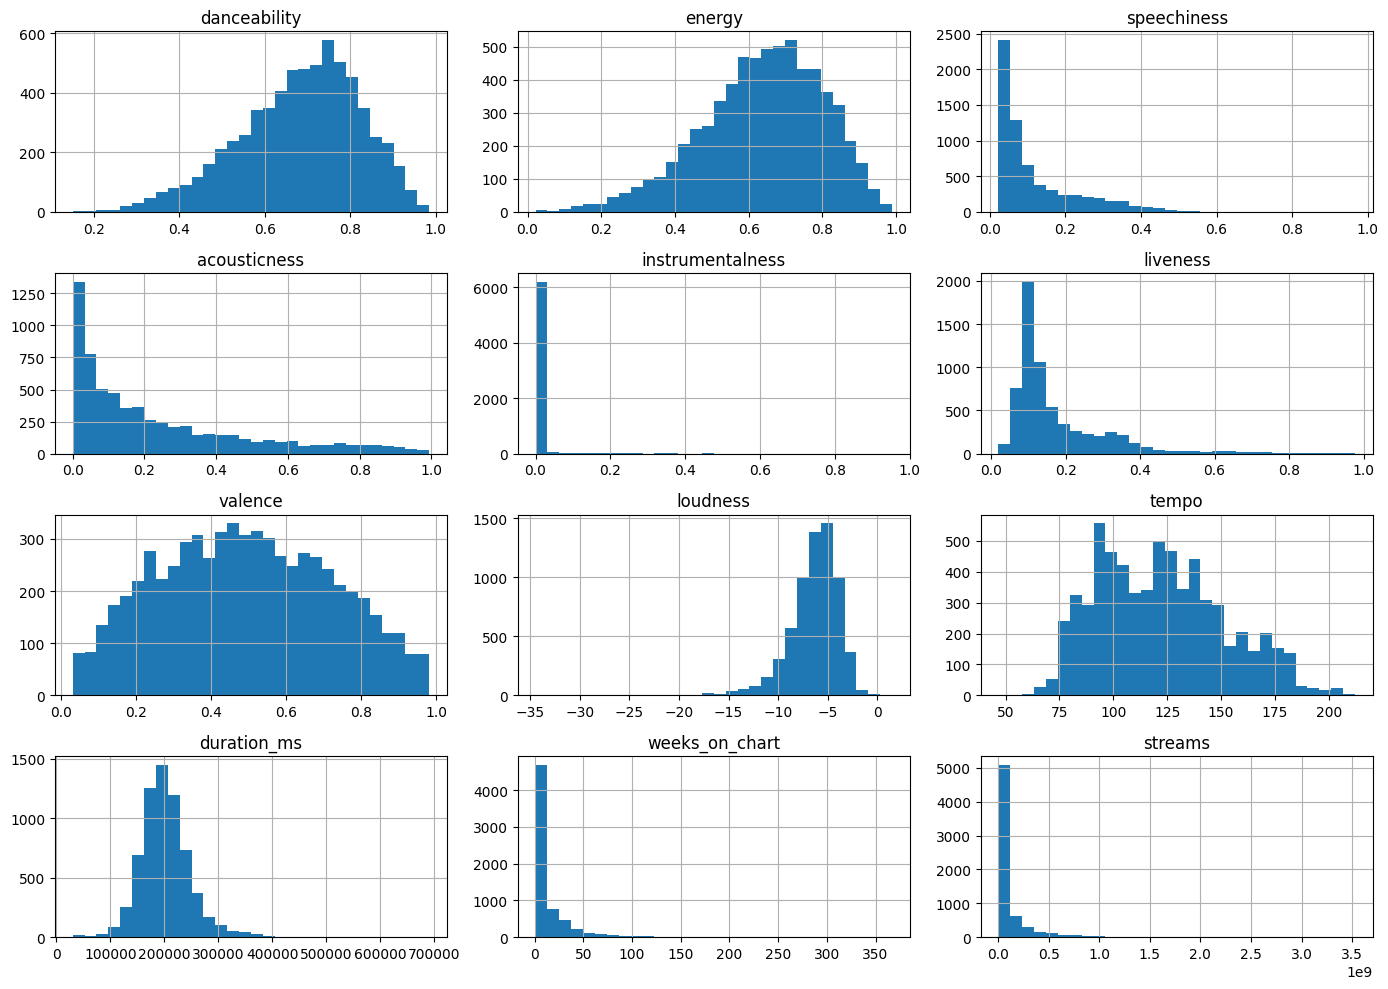

In [5]:
# Seleciona apenas colunas numéricas
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Plot de histogramas para os atributos numéricos
plt.figure(figsize=(14, 10))
df[numeric_cols].hist(bins=30, figsize=(14, 10))
plt.tight_layout()
plt.show()

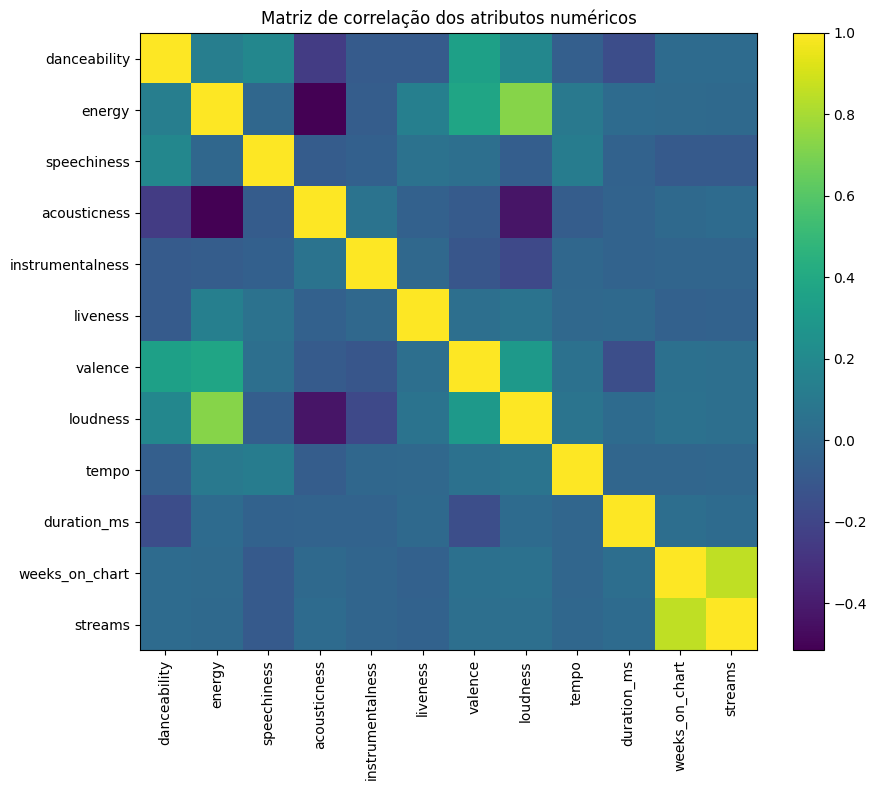

In [6]:
# Matriz de correlação entre atributos numéricos
corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Matriz de correlação dos atributos numéricos")
plt.tight_layout()
plt.show()

## 3. Metodologia e Preparação dos Dados

### 3.1 Definição do Problema

Nosso objetivo é construir um sistema de recomendação que, dada uma música de entrada,
seja capaz de sugerir faixas semelhantes com base em atributos sonoros (energia, dançabilidade,
valência etc.).

### 3.2 Seleção de Atributos e Normalização

A partir da base, selecionaremos apenas os atributos numéricos como entrada do modelo,
normalizando-os com **MinMaxScaler** para garantir que todas as variáveis estejam na mesma escala.


In [7]:
# Possíveis colunas de identificação que não devem entrar na NMF
possible_id_cols = [
    'track_id', 'track_name', 'artists', 'artist_name', 'album_name',
    'playlist_name', 'playlist_id', 'id'
]

id_cols = [c for c in possible_id_cols if c in df.columns]

# Atributos numéricos candidatos
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Se quisermos excluir algumas colunas numéricas específicas (como ano ou popularidade da modelagem),
# elas podem ser removidas aqui:
cols_to_exclude = [c for c in ['year', 'popularity'] if c in numeric_cols]

feature_cols = [c for c in numeric_cols if c not in cols_to_exclude]

print("Colunas usadas como atributos do modelo:")
print(feature_cols)

# Normalização Min-Max
scaler = MinMaxScaler()
X = scaler.fit_transform(df[feature_cols])

X[:5]

Colunas usadas como atributos do modelo:
['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo', 'duration_ms', 'weeks_on_chart', 'streams']


array([[0.71616766, 0.62572374, 0.04316928, 0.13178417, 0.        ,
        0.0684216 , 0.51789474, 0.79051801, 0.44888421, 0.2397188 ,
        0.04371585, 0.02978016],
       [0.24311377, 0.75806452, 0.75286381, 0.08268923, 0.        ,
        0.38681709, 0.42631579, 0.78365385, 0.87325195, 0.24757379,
        0.00273224, 0.00210433],
       [0.24191617, 0.91935484, 0.05462452, 0.00120974, 0.        ,
        0.08335945, 0.21473684, 0.81272232, 0.61254905, 0.29191688,
        0.33879781, 0.14460403],
       [0.56287425, 0.62365591, 0.56194315, 0.28872701, 0.        ,
        0.30742714, 0.66631579, 0.75136172, 0.73273115, 0.38559398,
        0.00273224, 0.00268304],
       [0.64311377, 0.78494624, 0.03160798, 0.03631061, 0.        ,
        0.05828894, 0.69052632, 0.82450534, 0.3040889 , 0.24731191,
        0.07923497, 0.08489551]])

## 4. Modelagem com Non-negative Matrix Factorization (NMF)

Vamos aplicar NMF para decompor a matriz de atributos em fatores latentes.

### 4.1 Busca do número de componentes

Testaremos diferentes números de componentes latentes e avaliaremos o **erro de reconstrução**
para escolher um valor adequado, equilibrando simplicidade do modelo e capacidade de representar os dados.


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Componentes:  4 | Erro de reconstrução: 23.3362


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Componentes:  6 | Erro de reconstrução: 15.7995


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Componentes:  8 | Erro de reconstrução: 10.6527


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Componentes: 10 | Erro de reconstrução: 6.7563


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Componentes: 12 | Erro de reconstrução: 1.9927
Componentes: 16 | Erro de reconstrução: 0.2466
Componentes: 20 | Erro de reconstrução: 0.2824


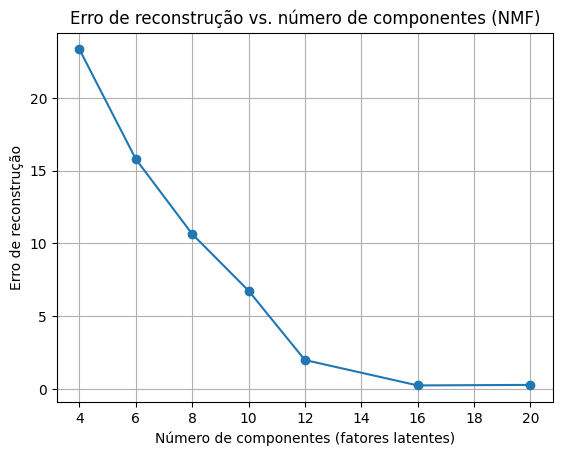

In [8]:
componentes_teste = [4, 6, 8, 10, 12, 16, 20]
reconstruction_errors = []

for n in componentes_teste:
    nmf = NMF(n_components=n, init='random', random_state=42, max_iter=500)
    W = nmf.fit_transform(X)
    H = nmf.components_
    X_recon = np.dot(W, H)
    error = np.linalg.norm(X - X_recon)
    reconstruction_errors.append(error)
    print(f"Componentes: {n:2d} | Erro de reconstrução: {error:.4f}")

# Plotando erro x número de componentes
plt.figure()
plt.plot(componentes_teste, reconstruction_errors, marker='o')
plt.xlabel("Número de componentes (fatores latentes)")
plt.ylabel("Erro de reconstrução")
plt.title("Erro de reconstrução vs. número de componentes (NMF)")
plt.grid(True)
plt.show()

In [9]:
# Escolhe o melhor número de componentes como o que tem menor erro de reconstrução
best_idx = int(np.argmin(reconstruction_errors))
best_n_components = componentes_teste[best_idx]
reconstruction_error_best = reconstruction_errors[best_idx]

print(f"Melhor número de componentes: {best_n_components}")
print(f"Erro de reconstrução correspondente: {reconstruction_error_best:.4f}")

# Treina modelo final de NMF
nmf_best = NMF(n_components=best_n_components, init='random', random_state=42, max_iter=500)
W_best = nmf_best.fit_transform(X)
H_best = nmf_best.components_

# Representação latente de cada música
item_factors = W_best
item_factors.shape

Melhor número de componentes: 16
Erro de reconstrução correspondente: 0.2466


(6513, 16)

## 5. Geração de Recomendações com Similaridade do Cosseno

Com a representação latente de cada música, calculamos a similaridade do cosseno entre faixas.
Dada uma música de entrada, buscamos as músicas mais próximas nesse espaço latente.


In [10]:
def get_recommendations(track_name, n_recs=10):
    """Retorna uma tabela com recomendações para uma música específica."""
    if 'track_name' not in df.columns:
        raise ValueError("A coluna 'track_name' não está presente no dataset.")
    
    mask = df['track_name'].str.lower() == track_name.lower()
    if not mask.any():
        raise ValueError(f"Música '{track_name}' não encontrada no dataset.")
    
    idx = np.where(mask)[0][0]
    
    # Vetor latente da música de consulta
    query_vec = item_factors[idx:idx+1]
    sims = cosine_similarity(query_vec, item_factors)[0]
    
    # Ordena por similaridade (descendente), ignorando a própria música
    similar_idx = np.argsort(-sims)
    similar_idx = [i for i in similar_idx if i != idx][:n_recs]
    
    recs = df.iloc[similar_idx].copy()
    recs['similarity'] = sims[similar_idx]
    
    # Adiciona metadados da música de consulta
    recs['query_track'] = df.loc[idx, 'track_name']
    if 'artists' in df.columns:
        recs['query_artist'] = df.loc[idx, 'artists']
    elif 'artist_name' in df.columns:
        recs['query_artist'] = df.loc[idx, 'artist_name']
    else:
        recs['query_artist'] = None
    
    # Define colunas de saída
    meta_cols = [c for c in ['track_name', 'artists', 'artist_name', 'album_name', 'year', 'popularity'] if c in recs.columns]
    cols = ['query_track', 'query_artist'] + meta_cols + ['similarity']
    
    return recs[cols]

### 5.1 Exemplo de Recomendações

Vamos pegar uma música de exemplo do dataset e gerar recomendações.


In [11]:
# Escolhe a primeira música do dataset como exemplo
example_track = df['track_name'].iloc[0]
print("Música de entrada:", example_track)

recs_example = get_recommendations(example_track, n_recs=10)
recs_example

Música de entrada: Still Got Time (feat. PARTYNEXTDOOR)


,query_track,query_artist,track_name,similarity
1361,Still Got Time (feat. PARTYNEXTDOOR),None,Uh Huh,0.997234
4042,Still Got Time (feat. PARTYNEXTDOOR),None,DEVASTATED,0.996678
6251,Still Got Time (feat. PARTYNEXTDOOR),None,Uh Huh,0.996471
1109,Still Got Time (feat. PARTYNEXTDOOR),None,Don't Stop The Music,0.996378
5677,Still Got Time (feat. PARTYNEXTDOOR),None,VACATION,0.996211
6329,Still Got Time (feat. PARTYNEXTDOOR),None,ELEVEN,0.995852
442,Still Got Time (feat. PARTYNEXTDOOR),None,History,0.995173
2128,Still Got Time (feat. PARTYNEXTDOOR),None,BRABA,0.995025
1136,Still Got Time (feat. PARTYNEXTDOOR),None,Explícale (feat. Bad Bunny),0.994937
31,Still Got Time (feat. PARTYNEXTDOOR),None,Cozy Little Christmas,0.994759


## 6. Métricas de Desempenho do Modelo

Embora não exista uma "verdade absoluta" de quais músicas **deveriam** ser recomendadas,
podemos analisar:

- **Erro de reconstrução** da NMF (quão bem os fatores latentes reconstroem os dados).
- **Similaridade média do Top-N**: o quão similares são, em média, as músicas recomendadas para várias músicas de entrada.


In [12]:
def compute_topk_similarity(k=10, n_samples=100, random_state=42):
    """Calcula a similaridade média do Top-k para um conjunto de músicas amostradas."""
    rng = np.random.default_rng(random_state)
    n = len(df)
    n_samples = min(n_samples, n)
    idxs = rng.choice(n, size=n_samples, replace=False)
    
    topk_means = []
    
    for idx in idxs:
        query_vec = item_factors[idx:idx+1]
        sims = cosine_similarity(query_vec, item_factors)[0]
        sims[idx] = -1  # ignora a própria música
        topk = np.sort(sims)[-k:]
        topk_means.append(topk.mean())
    
    return float(np.mean(topk_means)), float(np.std(topk_means))

mean_top10, std_top10 = compute_topk_similarity(k=10, n_samples=100)

metrics_df = pd.DataFrame({
    'metric': ['reconstruction_error', 'mean_top10_similarity', 'std_top10_similarity'],
    'value': [reconstruction_error_best, mean_top10, std_top10]
})

metrics_df

,metric,value
0,reconstruction_error,0.246594
1,mean_top10_similarity,0.984067
2,std_top10_similarity,0.020854
